# Using Y-factor method to calculate active component noise

## Introducing Y-factor method
The Y-factor method is a widely used technique in RF engineering to measure the noise figure/noise temperature of active components such as amplifiers and mixers. The method involves measuring the output noise power of the device under test (DUT) when it is connected to two different known input noise sources, typically referred to as the "hot" and "cold" sources.

$$
Y = \frac{P_{hot}}{P_{cold}}
$$

The hot and cold sources are often implemented using noise diodes turned on and off, or by using matched loads at different temperatures (e.g., room temperature and liquid nitrogen temperature). 

Characterizing this noise temperature is crucial for understanding the sensitivity of RF systems, especially for under one kelvin experiments where noise should be minimized. 

The Y-factor method serves another purpose in our calibration system, we have calibrator sources (i.e. a noise diode and blackbody). The spectral temperature of these sources need to be measured so that they could be effectively used to validate the whole system performance. The Y-factor method can be used to infer their temperatures. 

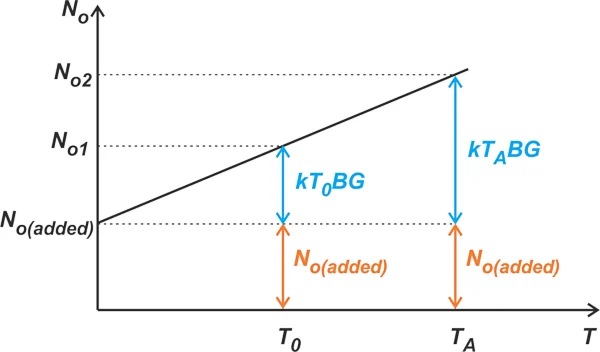

In [1]:
# import necessary modules
import os
from os.path import join as pjoin
import numpy as np
import skrf as rf
from matplotlib import pyplot as plt

pjoin = os.path.join
pbase = os.path.basename

In [2]:
# import relevant classes from highz_exp
from highz_exp.fit_temperature import Y_Factor_Thermometer
from highz_exp.s_params import S_Params
from highz_exp.spec_class import Spectrum
from highz_exp import plotter

# set up data paths
data_path = os.path.expanduser("~/Desktop/High-Z/SA_Measurements") # change this to your data directory
output_path = pjoin(data_path, 'Processed') # change this to your desired output directory
plot_path = pjoin(data_path, 'Plots') # change this to your desired plot directory
sparam_path = os.path.expanduser("~/Desktop/High-Z/S21Measurements") # change this to your S-parameter data directory

if os.path.exists(output_path) is False:
    os.makedirs(output_path)
if os.path.exists(plot_path) is False:
    os.makedirs(plot_path)

In [3]:
# define macros for plotting
# nchannels = 4
nfft = 32768
fs = 3276.8/4
fbins = np.arange(0, nfft//2)
df = fs/nfft
faxis = fbins*df
faxis_hz = faxis*1e6
freq_range = (0, 500) # MHz
y_41_5 = []
y_43 = []
for i in range(len(faxis)):
    y_41_5.append(-41.5)
    y_43.append(-43)

## Y-Factor Method without second-stage calibration
If our goal is not to measure the absolute noise temperature of the DUT, but rather to infer the temperature of some noise diodes, we can skip the second-stage calibration.

In [17]:
# Import data loading module, this is used to parse CSV files from Keysight spectrum analyzer.
from highz_exp import load_csv

# load data for 300K-77K measurements
file_LNA = pjoin(data_path, 'LNA01_BB.csv')
load_csv.split_csv_by_trace_name(file_LNA, 
                                 header_file=pjoin(output_path, 'LNA01_BB_header.csv'),
                                 data_file= pjoin(output_path, 'LNA01_BB_data.csv'))

# load data for ND and BB measurements
file_ND = pjoin(data_path, 'LNA01_ND.csv')
load_csv.split_csv_by_trace_name(file_ND, 
                                 header_file=pjoin(output_path, 'LNA01_ND_header.csv'),
                                 data_file= pjoin(output_path, 'LNA01_ND_data.csv'))

Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/LNA01_BB_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/LNA01_BB_data.csv (755 rows)
Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/LNA01_ND_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/LNA01_ND_data.csv (755 rows)


In [18]:
# parse data files into separate traces
traces_LNA = load_csv.parse_trace_data(pjoin(output_path, 'LNA01_BB_data.csv'))
LNA01_300K = Spectrum(traces_LNA['Trace A']['frequency'], traces_LNA['Trace A']['spectrum'], 
                      name='300K load - LNA01')
LNA01_BB013 = Spectrum(traces_LNA['Trace B']['frequency'], traces_LNA['Trace B']['spectrum'], 
                       name='BB013')
LNA01_BB016 = Spectrum(traces_LNA['Trace C']['frequency'], traces_LNA['Trace C']['spectrum'], 
                       name='BB016')
LNA01_77K = Spectrum(traces_LNA['Trace D']['frequency'], traces_LNA['Trace D']['spectrum'], 
                     name='77K load - LNA01')

Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 751 data points
Successfully parsed 4 traces with data


In [19]:
# load traces for all the other three measurements (ND01, ND02, BB014)
traces_ND = load_csv.parse_trace_data(pjoin(output_path, 'LNA01_ND_data.csv'))
LNA01_BB014 = Spectrum(traces_ND['Trace A']['frequency'], traces_ND['Trace A']['spectrum'], name='BB014')
LNA01_ND01 = Spectrum(traces_ND['Trace B']['frequency'], traces_ND['Trace B']['spectrum'], name='ND01')
LNA01_ND02 = Spectrum(traces_ND['Trace C']['frequency'], traces_ND['Trace C']['spectrum'], name='ND02')

Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 0 data points
Successfully parsed 3 traces with data


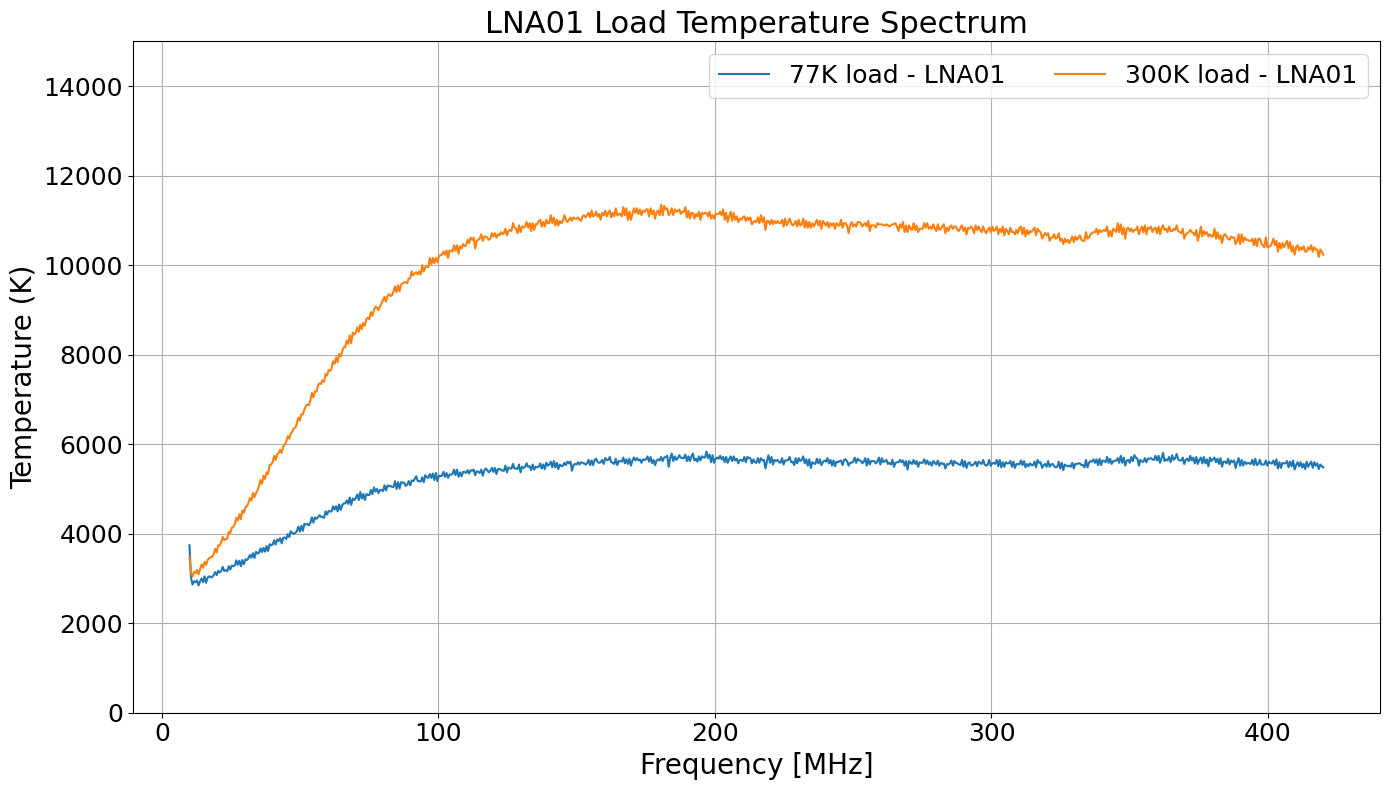

In [20]:
# plot in temperature

# convert the spectra from dBm to Kelvin, using the formula T = P / (k * B)
# where k is Boltzmann's constant and B is the channel bandwidth
LNA01_77K_temp = LNA01_77K.unit_convert('dBm', 'kelvin', channel_width=10**6)
# smooth the temperature spectra
# LNA01_77K_temp.smooth(inplace=True, window=11)

LNA01_300K_temp = LNA01_300K.unit_convert('dBm', 'kelvin', channel_width=10**6)
# LNA01_300K_temp.smooth(inplace=True, window=11)

plotter.plot_spectra([LNA01_77K_temp, LNA01_300K_temp], title='LNA01 Load Temperature Spectrum', 
                      ylabel='Temperature (K)', y_range=(0, 15000),
                      save_path=pjoin(plot_path, 'LNA01_Temperature_Spectrum.png'))

In [27]:
# despike and convert to power for Y-Factor calculation
# LNA01_300K.despike(threshold=2, window=80, replace='median')
# LNA01_77K.despike(threshold=2, window=80, replace='median')
dut_hot = LNA01_300K.unit_convert('dBm', 'milliwatt', channel_width=1e6).spec
dut_cold = LNA01_77K.unit_convert('dBm', 'milliwatt', channel_width=1e6).spec

# construct the Y-Factor thermometer object, 
# this has the functionalities to calculate and plot the noise temperature and gain of the LNA 
# based on the hot-cold measurements
LNA_thermo = Y_Factor_Thermometer(LNA01_300K.freq, dut_hot, dut_cold,
                                    DUT_name='LNA01', T_hot=301, T_cold=77, RBW=1e6)

In [28]:
smoothed_thermo = LNA_thermo.smooth(inplace=False, smoothing_kwargs={"window":60})

In [29]:
BB013_Kelvin = LNA01_BB013.unit_convert('dBm', 'kelvin', channel_width=1e6, inplace=False)
BB013_Kelvin_despiked = BB013_Kelvin.despike(threshold=2, window=31, replace='median', inplace=False)

In [30]:
with open(pjoin(sparam_path, 'LNA1.S2P'), 'r') as f:
    s21_ntwk = rf.Network(f)
BB013_inferred = smoothed_thermo.infer_temp_with_known_gain(BB013_Kelvin_despiked, s21_ntwk)

In [31]:
LNA_s21 = S_Params(pjoin(sparam_path, 'LNA1.S2P'), labels=['From VNA'])
LNA_s21.ntwk_dict['Hot-Cold'] = smoothed_thermo.export_gain(None)

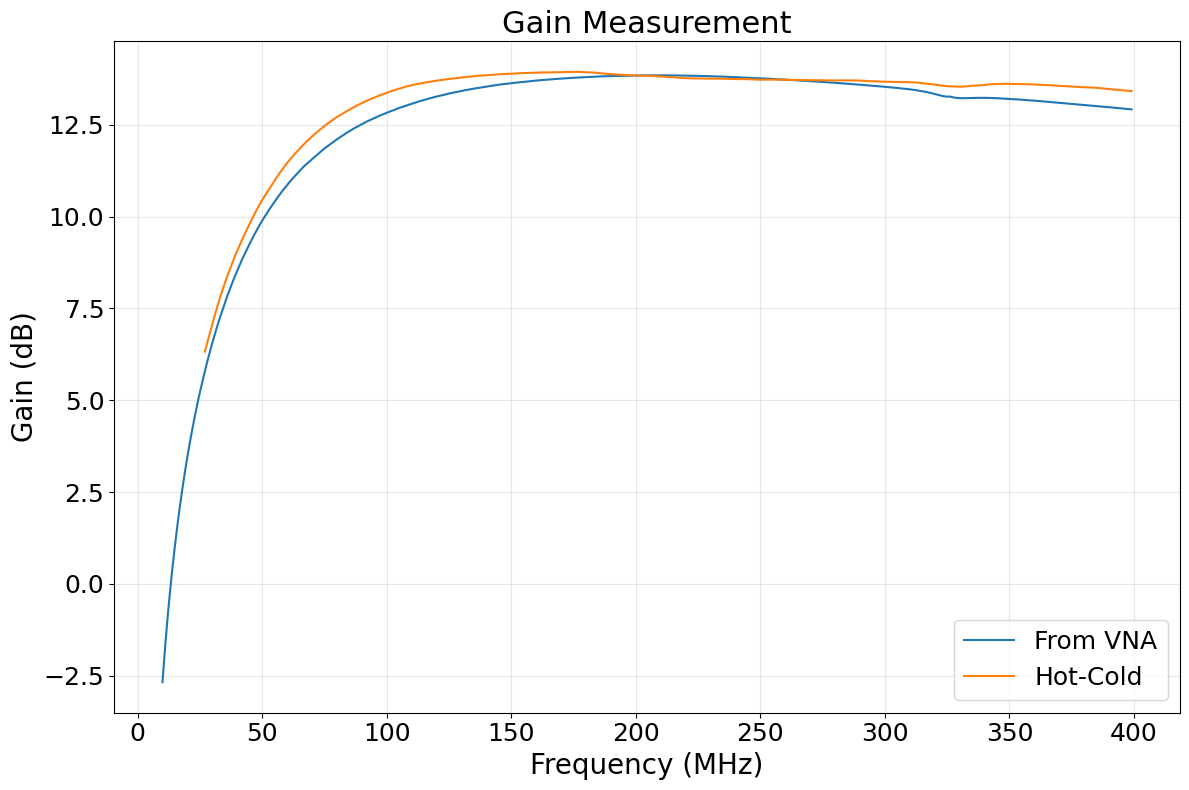

In [32]:
LNA_s21.interpolate_all(np.arange(10e6, 400e6, 1e6))
LNA_s21.plot_gain()

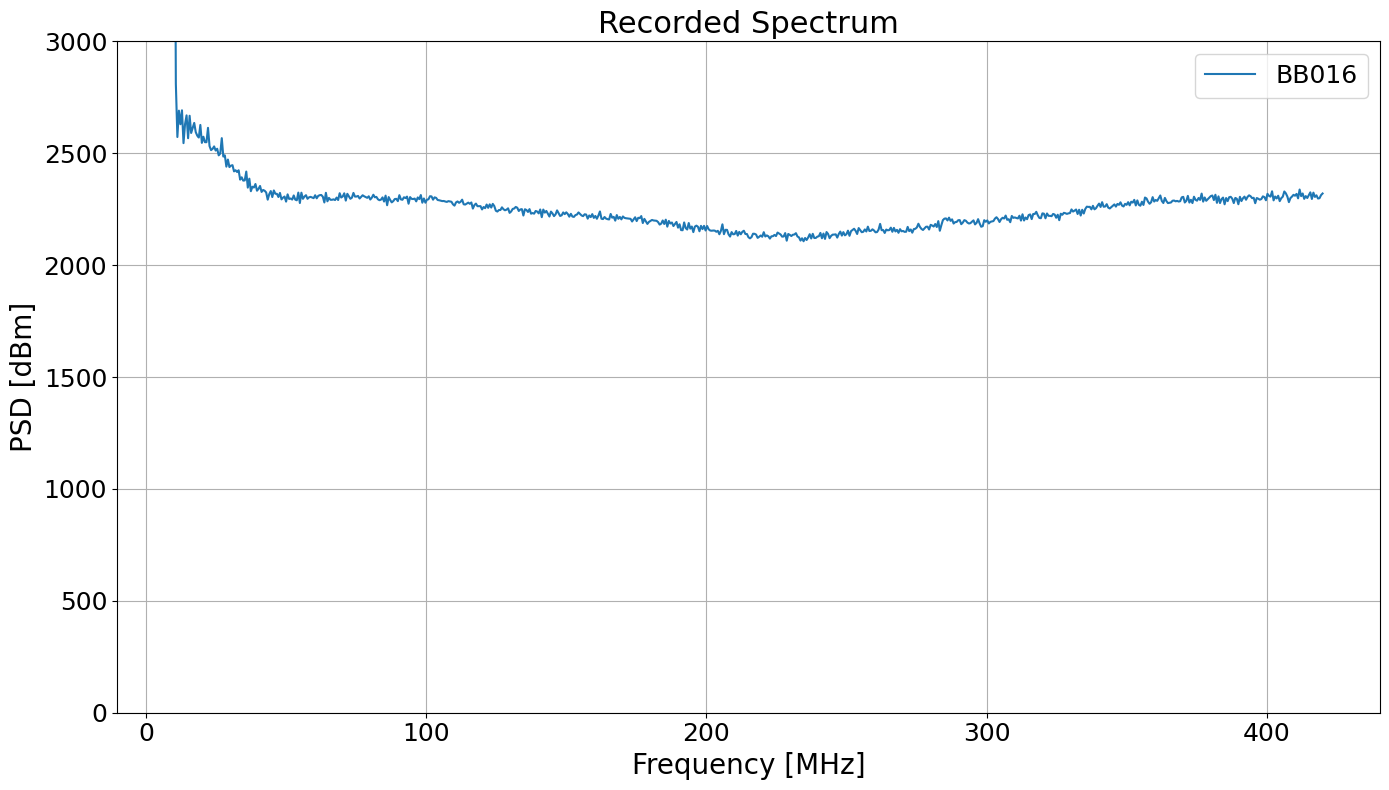

In [16]:
BB016_inferred = smoothed_thermo.infer_temp_with_known_gain(LNA01_BB016.unit_convert('dBm', 'kelvin', channel_width=1e6, inplace=False), s21_ntwk)
BB016_inferred.plot(y_range=(0, 3000))

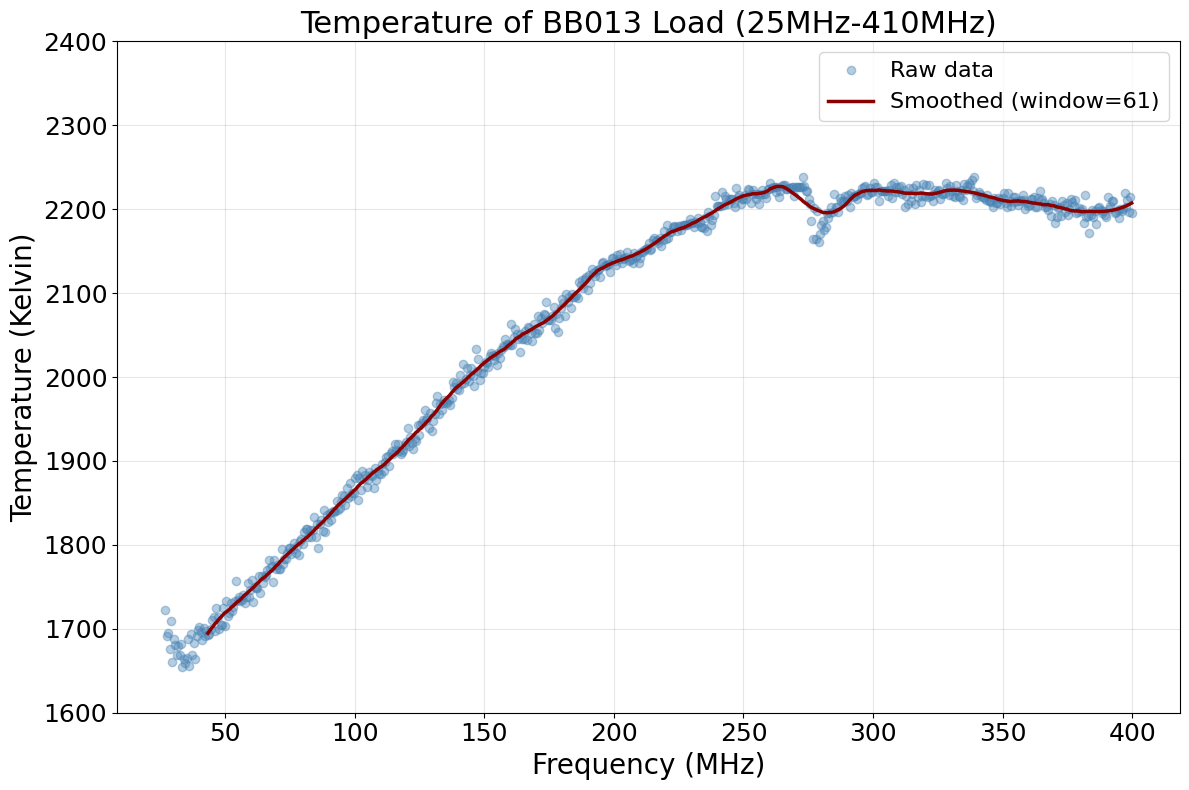

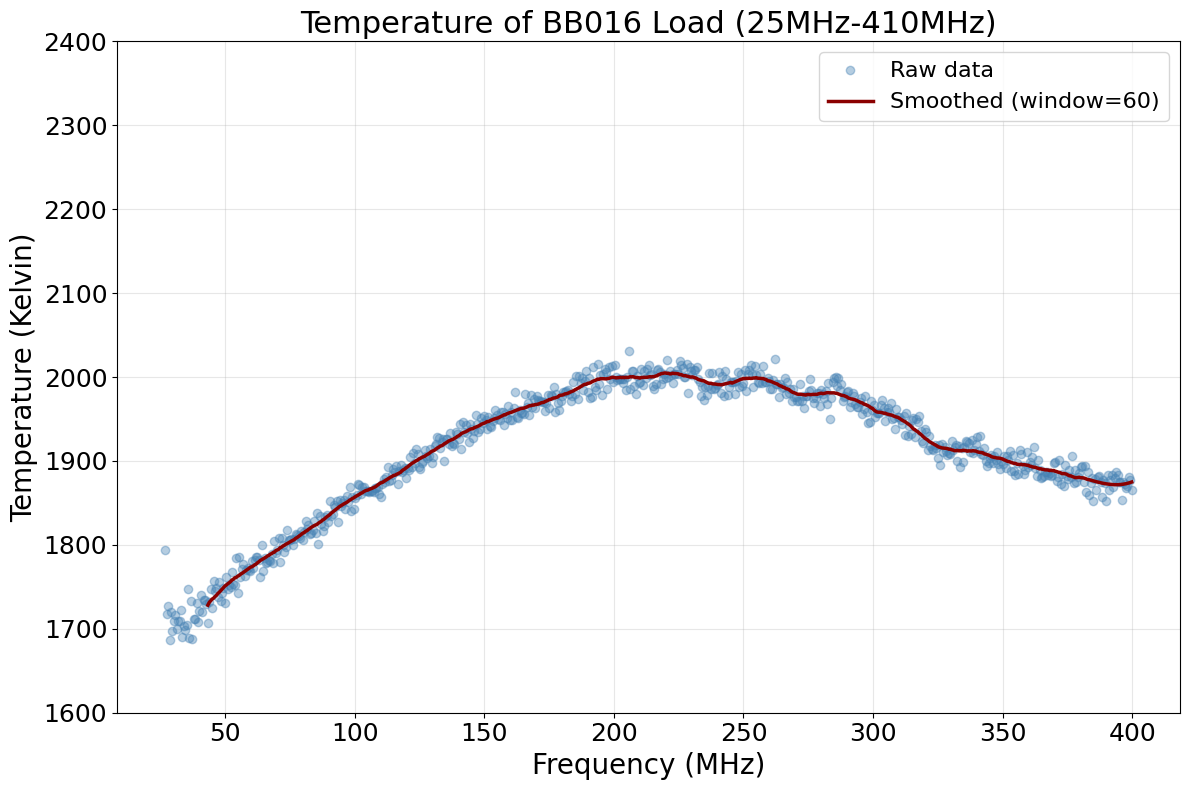

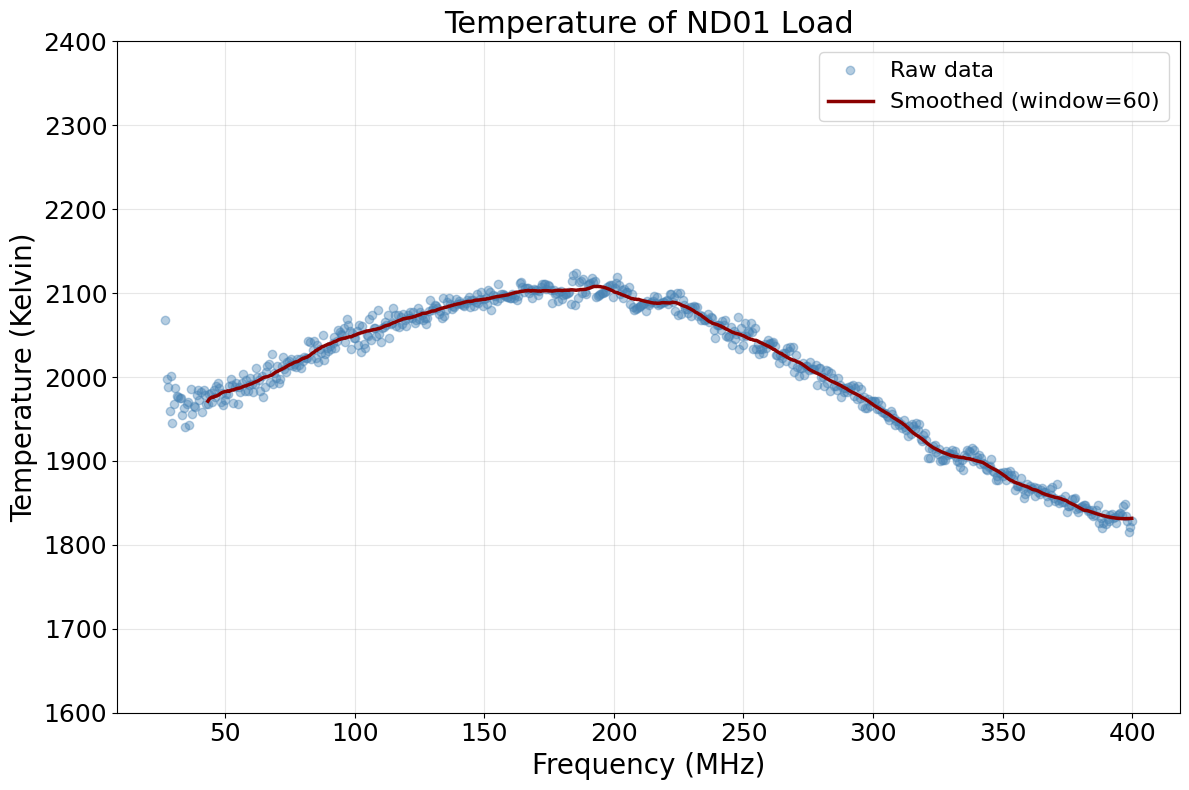

In [55]:
# LNA01_BB013.despike(threshold=5)
# LNA_thermo.smooth(inplace=True, smoothing_kwargs={"window":60})
BB013_inferred = smoothed_thermo.infer_temperature(BB013_Kelvin_despiked,  
                            ymax=2400, ymin=1600,
                            window_size=61,
                            title='Temperature of BB013 Load (25MHz-410MHz)',
                            save_path=pjoin(plot_path, 'BB013_Temperature_smoothed.png'))
                            # save_path=pjoin(plot_path, 'LNA01_Inferred_Temperature_BB013.png'))
BB016_inferred = smoothed_thermo.infer_temperature(LNA01_BB016.unit_convert('dBm', 'kelvin', 
                            channel_width=1e6, inplace=False), 
                            ymax=2400, ymin=1600,
                            window_size=60,
                            title='Temperature of BB016 Load (25MHz-410MHz)')
                            # save_path=pjoin(plot_path, 'BB016_Temperature.png'))
ND01_inferred = smoothed_thermo.infer_temperature(
    LNA01_ND01.unit_convert('dBm', 'kelvin', channel_width=1e6, inplace=False).despike(threshold=2), 
    ymax=2400, ymin=1600,
    window_size=60,
    title='Temperature of ND01 Load')
    # save_path=pjoin(plot_path, 'ND01_Temperature.png'))

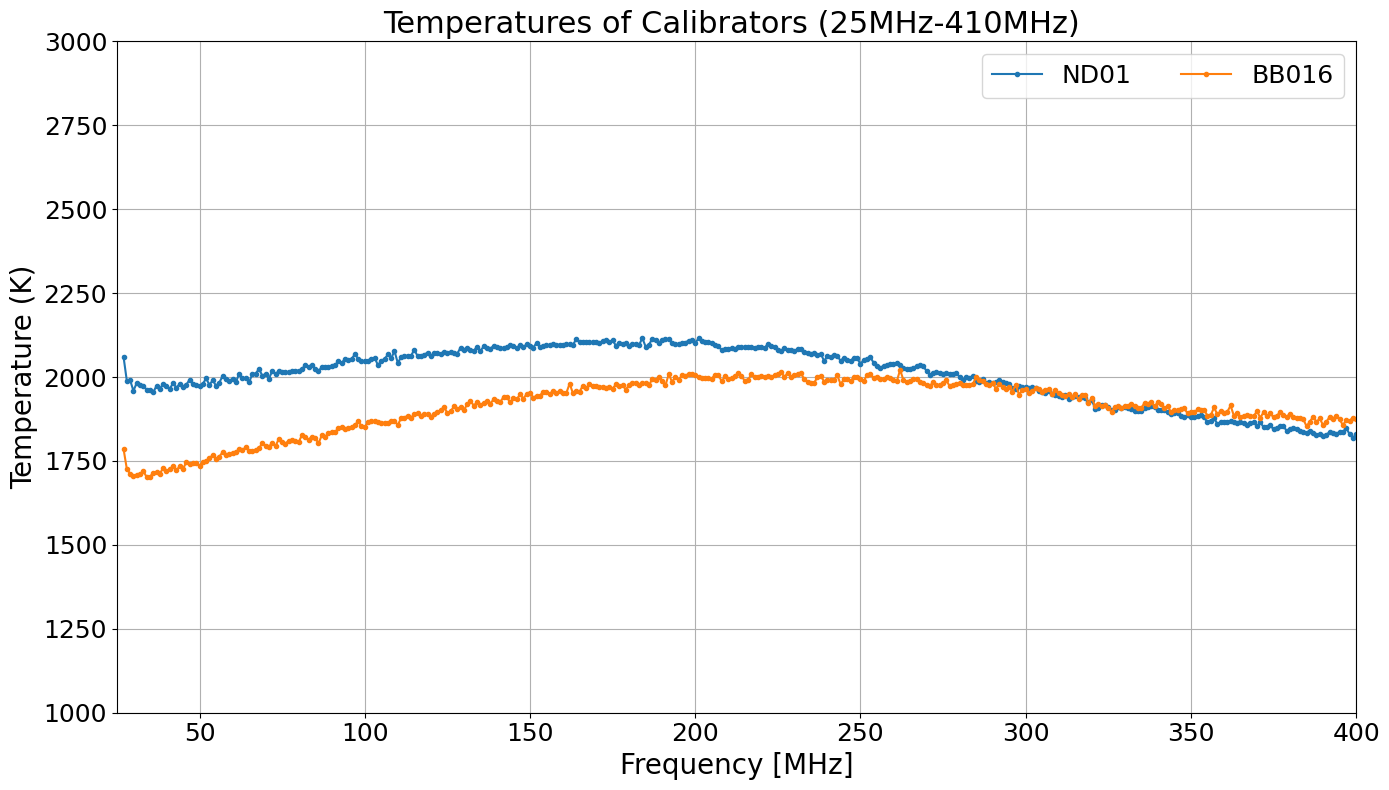

In [62]:
BB013_inferred = BB013_inferred.resample(new_freq=np.arange(20e6, 410e6, 1e6))
BB016_inferred = BB016_inferred.resample(new_freq=np.arange(20e6, 410e6, 1e6))
ND01_inferred = ND01_inferred.resample(new_freq=np.arange(20e6, 410e6, 1e6))

plotter.plot_spectra([ND01_inferred, BB016_inferred], title='Temperatures of Calibrators (25MHz-410MHz) ',
                     ylabel='Temperature (K)', y_range=(1000, 3000),
                     freq_range=(25, 400), marker='o', markersize=3,
                     save_path=pjoin(plot_path, 'Cal_Temperature.png'))

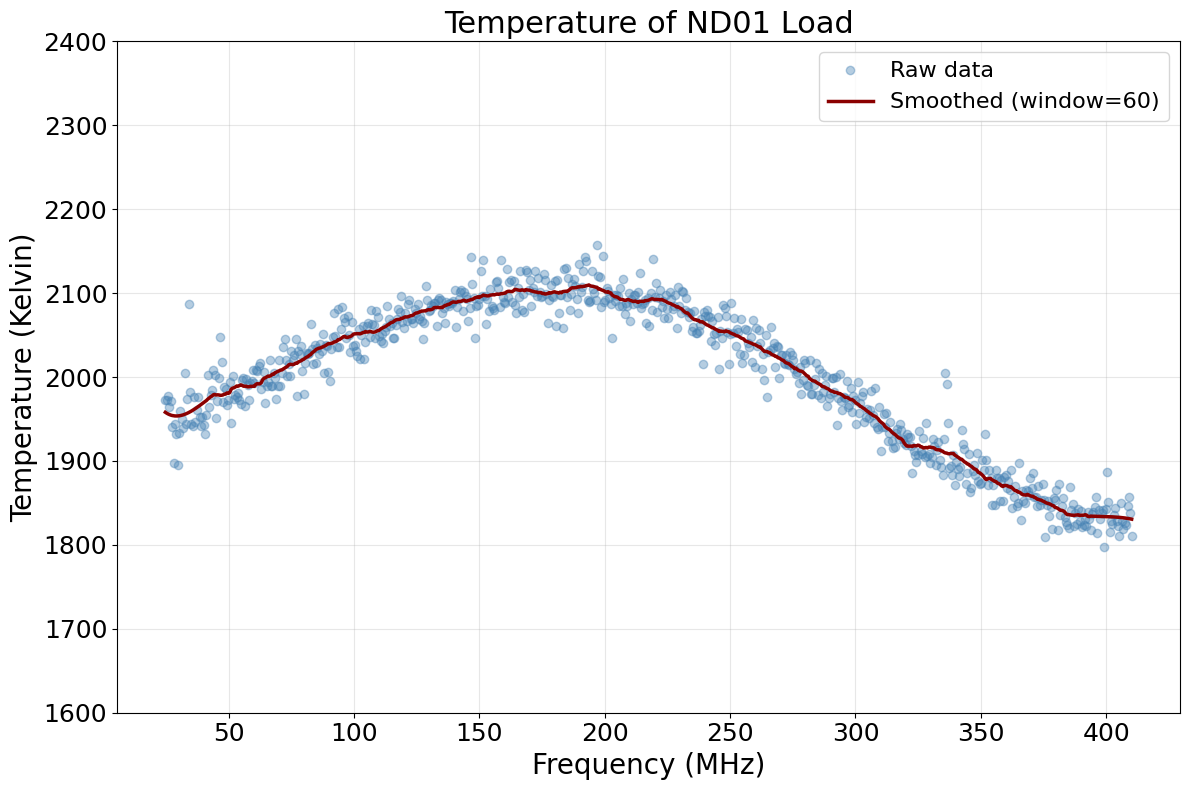

In [88]:
ND01_inferred = LNA_thermo.infer_temperature(
    LNA01_ND01.unit_convert('dBm', 'kelvin', channel_width=1e6, inplace=False), 
    start_freq=25, end_freq=410, ymax=2400, ymin=1600,
    window_size=60,
    title='Temperature of ND01 Load',
    save_path=pjoin(plot_path, 'ND01_Temperature.png'))

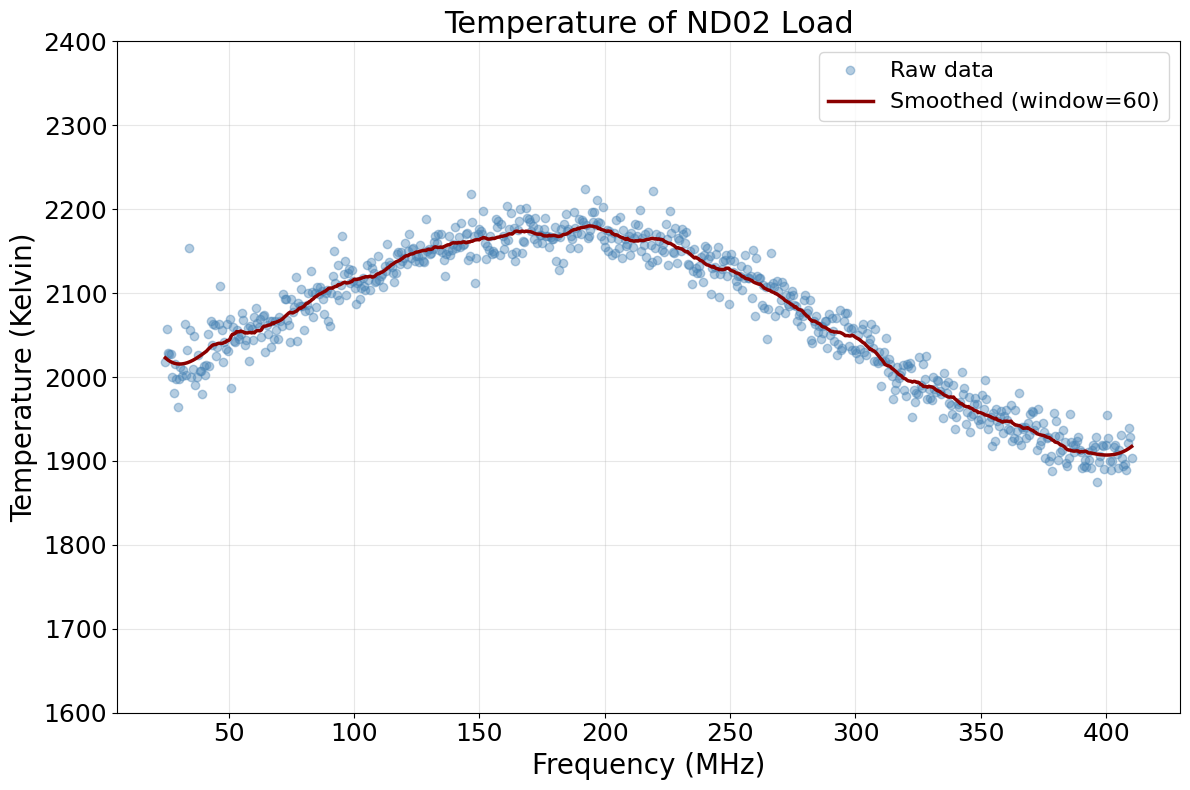

In [89]:
ND02_inferred = LNA_thermo.infer_temperature(
    LNA01_ND02.unit_convert('dBm', 'kelvin', channel_width=1e6, inplace=False), 
    start_freq=25, end_freq=410, ymax=2400, ymin=1600,
    window_size=60,
    title='Temperature of ND02 Load',
    save_path=pjoin(plot_path, 'ND02_Temperature.png'))

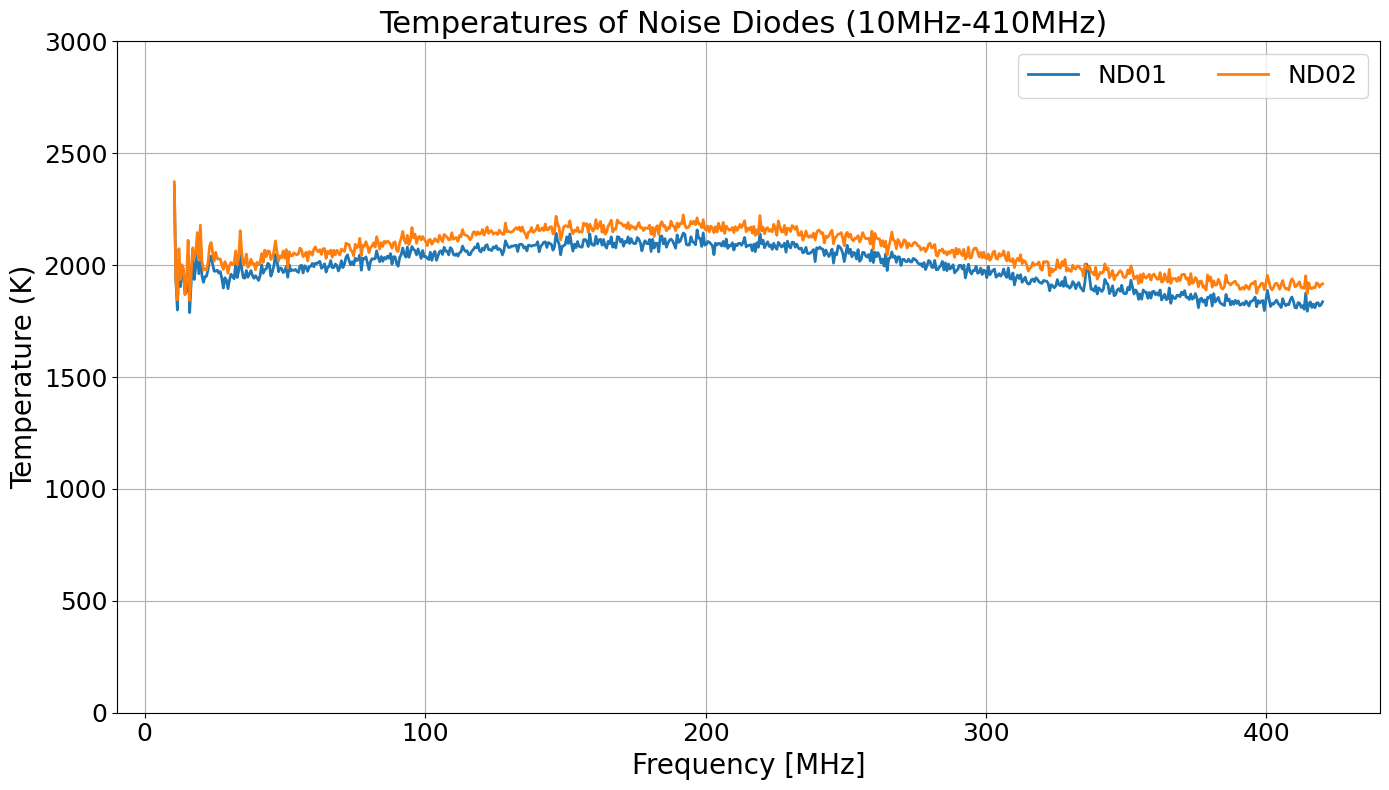

In [90]:
# plot the inferred temperatures of the two noise diodes together for comparison
plotter.plot_spectra([ND01_inferred, ND02_inferred], title='Temperatures of Noise Diodes (10MHz-410MHz) ',
                     ylabel='Temperature (K)', y_range=(0, 3000),
                     save_path=pjoin(plot_path, 'ND01_ND02_Temperature.png'))

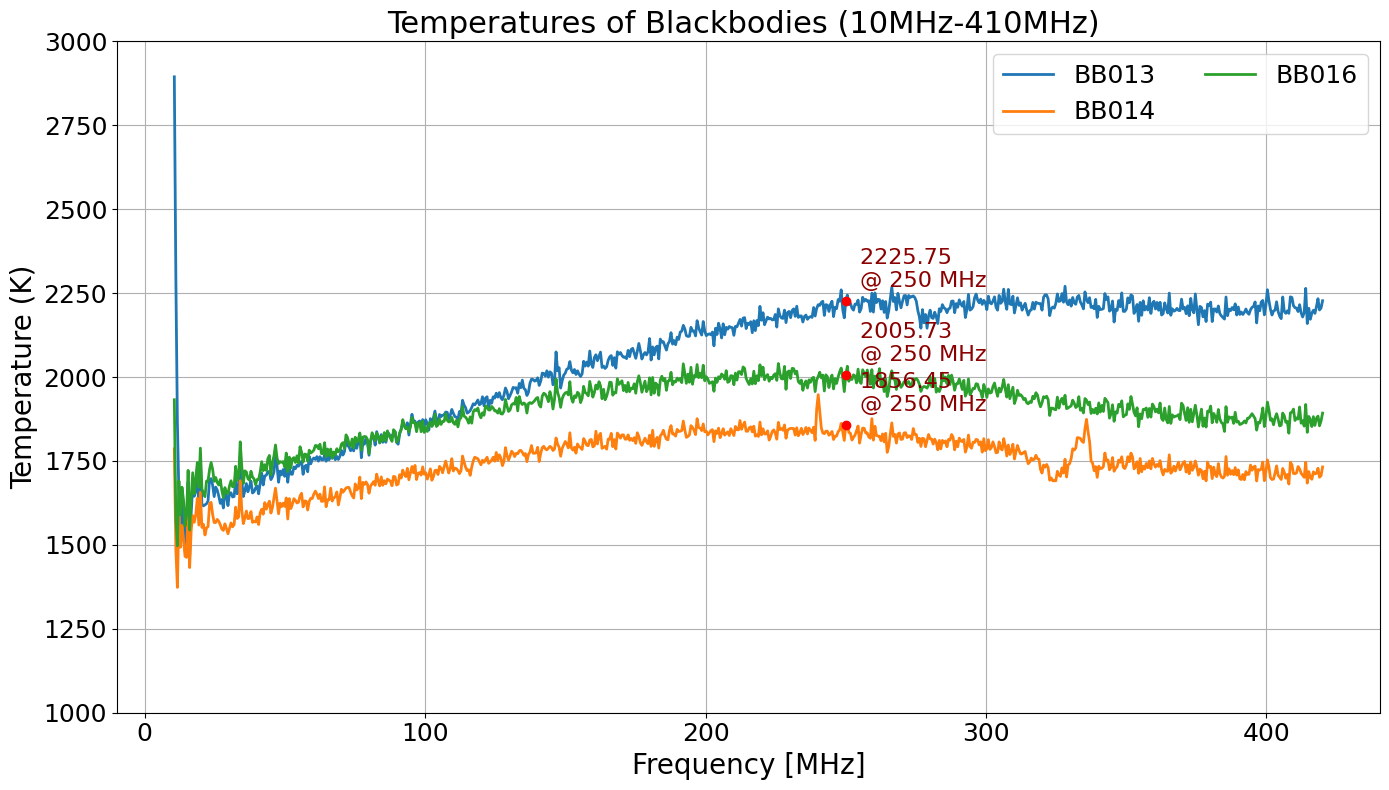

In [97]:
# plot the inferred temperatures of the two noise diodes together for comparison
plotter.plot_spectra([BB013_inferred, BB014_inferred, BB016_inferred], title='Temperatures of Blackbodies (10MHz-410MHz) ',
                     ylabel='Temperature (K)', y_range=(1000, 3000),
                     marker_freqs=[250],
                     save_path=pjoin(plot_path, 'BBs_Temperature.png'))

## Y-Factor Method with second-stage calibration
Since spectrum analyzer brings its own noise figure, we need to calibrate it out to get accurate measurement of the DUT noise temperature. This is done by performing a second-stage calibration with hot and cold loads.

In total, four measurements are needed:
1. hot load connected to 2nd stage amplifier + Spectrum Analyzer (SA)
2. cold load connected to 2nd stage amplifier + SA
3. hot load connected to 1st stage DUT + 2nd stage amplifier + SA
4. cold load connected to 1st stage DUT + 2nd stage amplifier + SA